### Import Module

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt
import cv2
from random import randint               
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential  
import tensorflow as tf
from tqdm import tqdm

### Class Indices

In [2]:
class_names = ['NH', 'NL', 'PH', 'PL']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
IMAGE_SIZE = (120, 120)

### Loading the datasets

In [3]:
def load_data():
    """
        Load the data:
            - 600 images to train the network.
            - 120 images to evaluate how accurately the network learned to classify images.
    """
    filters = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    datasets = ['datasets/train', 'datasets/test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                image = cv2.filter2D(image,-1,filters)
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

 20%|███████████████▋                                                                | 76/387 [00:00<00:00, 754.48it/s]

Loading datasets/train


  0%|                                                                                           | 0/97 [00:00<?, ?it/s]

Loading datasets/test


100%|█████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 717.41it/s]


#### Shuffle the datasets

In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

#### Exploring the datasets

In [6]:
# Exploring Datasets

n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of Class: {}".format(nb_classes))
print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of Class: 4
Number of training examples: 1579
Number of testing examples: 385
Each image is of size: (120, 120)


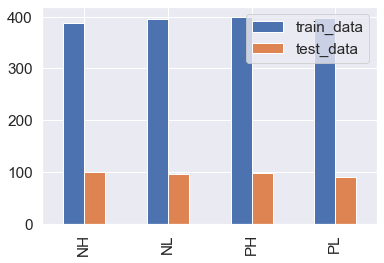

In [7]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train_data': train_counts,
                    'test_data': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

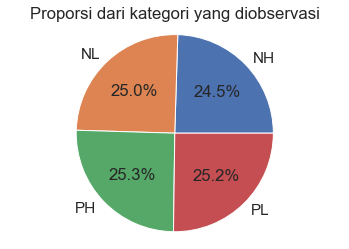

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%'
        )
plt.axis('equal')
plt.title('Proporsi dari kategori yang diobservasi')
plt.show()

#### Data Normalization

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

#### Data Visualization

In [10]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

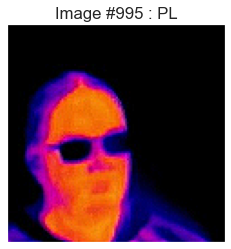

In [11]:
display_random_image(class_names, train_images, train_labels)

In [12]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(20,20))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(50):
        plt.subplot(10,10,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

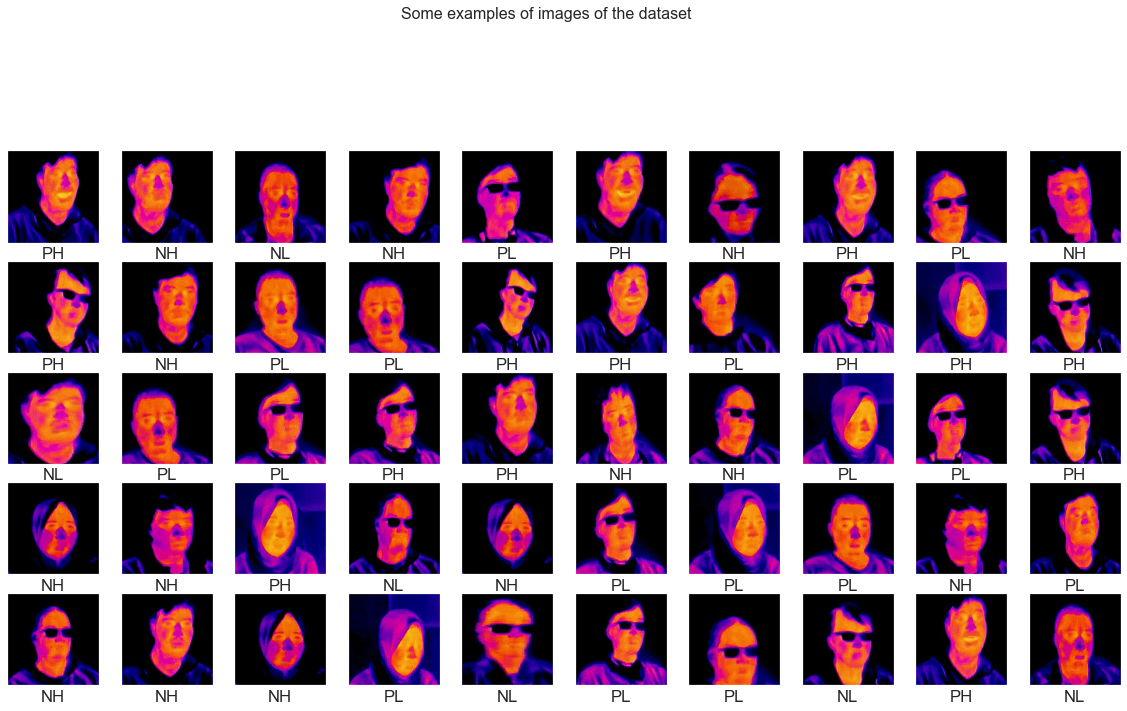

In [13]:
display_examples(class_names, train_images, train_labels)

### CNN Architecture

In [14]:
# CNN models

model = Models.Sequential()

# CNN Architecture

model.add(Layers.Conv2D(32,kernel_size=(3,3), padding='same', activation='relu',input_shape=(120, 120, 3)))
model.add(Layers.MaxPool2D(2,2))
model.add(Layers.Conv2D(64,kernel_size=(3,3), padding='same', activation='relu'))
model.add(Layers.MaxPool2D(2,2))
model.add(Layers.Conv2D(128,kernel_size=(3,3), padding='same', activation='relu'))
model.add(Layers.MaxPool2D(2,2))
model.add(Layers.Conv2D(256,kernel_size=(3,3), padding='same',  activation='relu'))
model.add(Layers.MaxPool2D(2,2))

# ANN Architecture

model.add(Layers.Flatten())

model.add(Layers.Dropout(0.2))
model.add(Layers.Dense(1000, activation="relu"))
model.add(Layers.Dropout(0.2))
model.add(Layers.Dense(500, activation="relu"))
model.add(Layers.Dropout(0.2))
model.add(Layers.Dense(100, activation="relu"))
model.add(Layers.Dropout(0.2))
model.add(Layers.Dense(4, activation='softmax'))

# Compiling Model

model.compile(optimizer=Optimizer.Adam(lr=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#### Model Summary

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

#### Training Section

In [16]:
import time

# START OF TIME
start = time.time()

### MODEL FITTING
history = model.fit(train_images, 
                    train_labels, 
                    batch_size= 16,
                    epochs= 30,
                    validation_split=0.2
                    )
### MODEL FITTING

# END OF TIME
end = time.time()

# RESULT
print("Time elapsed for this training section: {0:.2f}s".format(end - start))

# EPOCHS RUNTIME

Epoch 1/30
79/79 [==============================] - 18s 189ms/step - loss: 1.3755 - accuracy: 0.3428 - val_loss: 1.3234 - val_accuracy: 0.5127
Epoch 2/30
79/79 [==============================] - 12s 153ms/step - loss: 1.3104 - accuracy: 0.5151 - val_loss: 1.1463 - val_accuracy: 0.6772
Epoch 3/30
79/79 [==============================] - 12s 153ms/step - loss: 1.1467 - accuracy: 0.5512 - val_loss: 0.8779 - val_accuracy: 0.6994
Epoch 4/30
79/79 [==============================] - 12s 153ms/step - loss: 0.9217 - accuracy: 0.6757 - val_loss: 0.7251 - val_accuracy: 0.6677
Epoch 5/30
79/79 [==============================] - 12s 153ms/step - loss: 0.7259 - accuracy: 0.7325 - val_loss: 0.5675 - val_accuracy: 0.8323
Epoch 6/30
79/79 [==============================] - 12s 153ms/step - loss: 0.6410 - accuracy: 0.7784 - val_loss: 0.4785 - val_accuracy: 0.8481
Epoch 7/30
79/79 [==============================] - 12s 152ms/step - loss: 0.5815 - accuracy: 0.7874 - val_loss: 0.4187 - val_accuracy: 0.8639

#### Model Evaluation

In [1]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

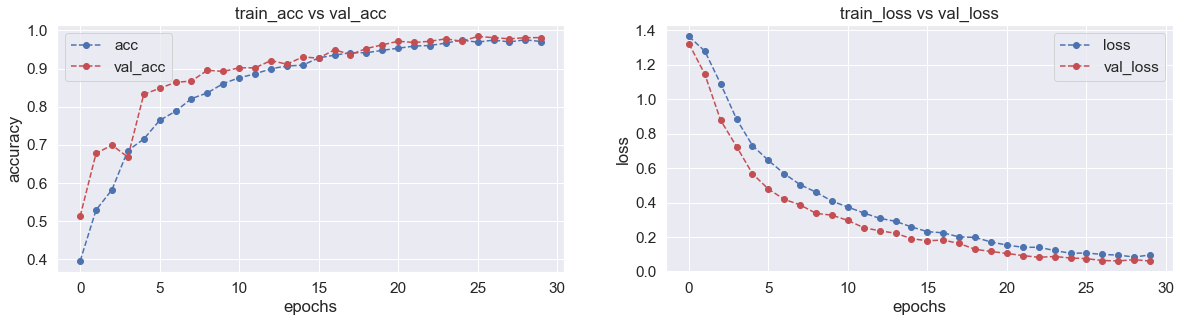

In [18]:
plot_accuracy_loss(history)

In [25]:
import time

# START OF TIME
start2 = time.time()

loss, acc = model.evaluate(test_images, test_labels)

print("System Validation Accuracy : {0:.2f}%".format(acc*100))
print("System Loss : {0:.2f}%".format(loss))

# END OF TIME
end2 = time.time()

# RESULT
print("Time elapsed for this training section: {0:.2f}s".format(end2 - start2))

# EPOCHS RUNTIME

13/13 [==============================] - 1s 66ms/step - loss: 0.3839 - accuracy: 0.9273
System Validation Accuracy : 92.73%
System Loss : 0.38%
Time elapsed for this training section: 1.19s


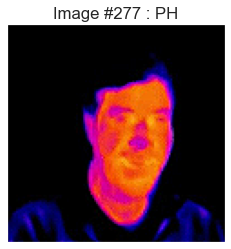

In [20]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [21]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 50 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

IndexError: index 28 is out of bounds for axis 0 with size 28

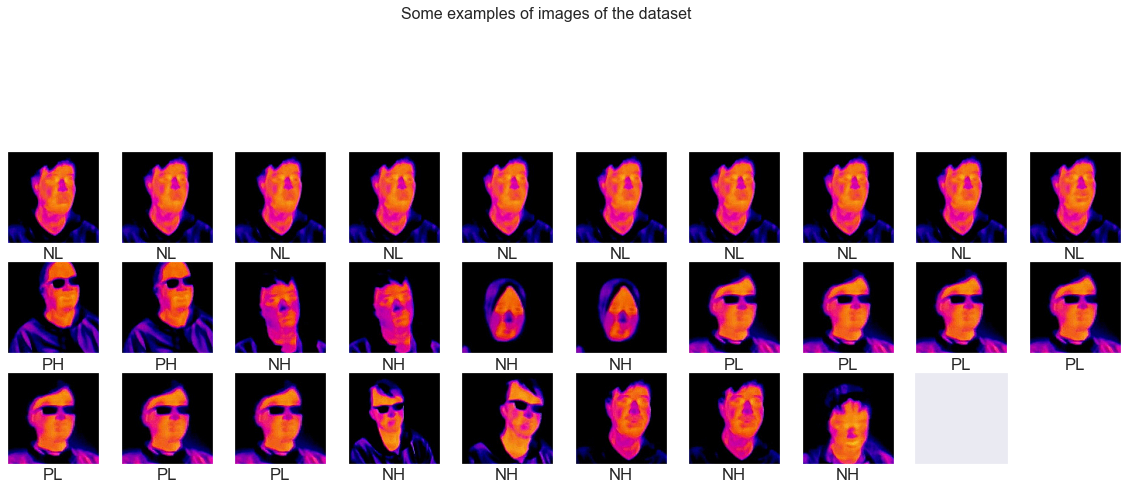

In [22]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

### Confusion Matrix

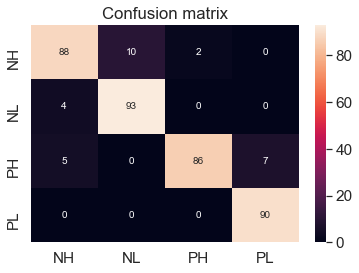

In [26]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [27]:
model.save('fer_model_f1.h5')